In [1]:
import os
import mne
import pandas as pd
import datetime
from scipy import ndimage
import polars as pl
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import docx


## Helper functions

In [2]:

def file_to_lazy_frame(filename):
    return pl.read_csv(filename, columns=['ts', 'z'], use_pyarrow=True).select([pl.col('ts').cast(pl.Datetime), pl.col('z').cast(pl.Int16)]).interpolate().filter(pl.col('ts').is_not_null()).filter(pl.col('z').is_not_null())




def np_bandpass_filt(sig,cutoff,fs,mode):
    nyq = 0.5*fs
    wn = cutoff/nyq
    sos = signal.butter(4, wn, btype=mode,output='sos')
    return signal.sosfiltfilt(sos,sig,axis=0)


def shannon_energy(x):
    x_env = -x**2 * np.log(x**2)
    return(x_env)

def bandpass_filt(sig,cutoff,fs,mode):
    nyq = 0.5*fs
    wn = cutoff/nyq
    sos = signal.butter(4, wn, btype=mode,output='sos')
    return pd.DataFrame(data=signal.sosfiltfilt(sos,sig,axis=0),columns=sig.columns,index=sig.index)

In [3]:
def read_edf(path, start_time):
    df = mne.io.read_raw_edf(path).to_data_frame()
    df['time'] = pd.to_timedelta(df['time'], unit='s') + start_time
    df.set_index('time', inplace=True)
    df = df['PR']
    df_resampled = df.resample('1ms').asfreq()
    df_upsampled = df_resampled.interpolate(method='linear')
    
    ret = pd.DataFrame()
    ret['hr'] = df_upsampled.values*10e-7
    ret.set_index(df_upsampled.index.values, inplace=True)

    return ret


def process_ma(path):
    xl0 = file_to_lazy_frame(path)
    xl1 = file_to_lazy_frame(path)

    # join data from each imu by the millisecond
    xlz = xl0.groupby_dynamic('ts', every='1ms').agg(pl.mean('z')).rename({'z': 'z0'}).join(xl1.groupby_dynamic('ts', every='1ms').agg(pl.mean('z')).rename({'z': 'z1'}), on='ts', how='inner').select([pl.col('ts'), pl.col('z0').cast(pl.Int16), pl.col('z1').cast(pl.Int16)])

    # convert into a pandas dataframe
    ma_df = xlz.to_pandas()
    ma_df.set_index('ts', inplace=True)
    ma_df = ma_df['z0']

    # Frequency calculation based on dataframe, usually 999.9999
    fs = 1e-09**-1/np.median(np.diff(ma_df.index.values.astype(np.int64)))

    # 20Hz low pass
    ma_z_filt = np_bandpass_filt(ma_df, 1/0.05, fs, 'lowpass')

    # 20 - 51 Band pass
    test_bp = np_bandpass_filt(ma_z_filt,(20,51),fs,'bandpass')

    # CWT using morlet, then extract local maximums
    ma_lp_bp_cwt = signal.cwt(test_bp,signal.morlet,np.arange(1,20))
    cwt_pk = ma_lp_bp_cwt.T[:,1:15]
    cwt_pks = cwt_pk.max(axis=1)

    # Shannon energy followed by gaussian_filter on absolute values of shannon energy
    cwt_se = shannon_energy(cwt_pks)
    cwt_se_gs = ndimage.gaussian_filter(np.abs(cwt_se),sigma=25)


    # low-pass to extract waves that have roughly 700 ms width
    single_peak = np_bandpass_filt(cwt_se_gs, 1/0.7, fs, 'lowpass')
    peaks, _ = signal.find_peaks(single_peak,height=2e-7,distance=350)

    peak_intervals = np.diff(peaks) / fs

    # Dynamic HR calculation

    heart_rates = 60 / peak_intervals
    ret = pd.DataFrame()


    # Upsample HR to match dataframe size
    filled_hr = np.zeros(len(ma_df))
    for i, p in enumerate(peaks[:-1]):
        filled_hr[p] = heart_rates[i]
    filled_hr = pd.Series(filled_hr).replace(0, np.nan)
    filled_hr = filled_hr.fillna(method='ffill')
    filled_hr = filled_hr.fillna(method='bfill')

    # Low pass filter to reduce noise
    filled_hr = np_bandpass_filt(filled_hr, 0.05, 1000, 'lowpass')


    
    ret['z'] = ma_df.values
    ret['ma_hr'] = filled_hr
    ret.set_index(ma_df.index.values, inplace=True)
    ret.index = ret.index - pd.Timedelta(hours=5)
    return ret


def label_dataframe(X, doc, doc_start_time):
    doc = docx.Document(doc)
    for table in doc.tables:
        # Extract the contents of each cell in the table
        data = [[cell.text for cell in row.cells] for row in table.rows]
        
        # Create a pandas DataFrame from the extracted data
        df = pd.DataFrame(data[1:], columns=data[0])

    stage_values = df['Stage'].values.T.flatten()
    epoch_values = df['Epoch'].values.T.flatten()

    label_df = pd.DataFrame()
    label_df['Stage'] = stage_values
    label_df['Epoch'] = epoch_values

    doc_start_time = doc_start_time
    increment = datetime.timedelta(seconds=30)
    num_periods = len(label_df)
    time_index = pd.date_range(start=doc_start_time, periods=num_periods, freq=increment)
    label_df.set_index(time_index, inplace=True)
    final_df = pd.concat([X, label_df], axis=1)
    final_df['Stage'] = final_df['Stage'].fillna(method='ffill')
    final_df['Epoch'] = final_df['Epoch'].fillna(method='ffill')
    label_index = list(set(final_df['Stage']))
    label_map={
        '<Stage>Wake':0,
        '<Stage>NREM 1':1,
        '<Stage>NREM 2':2,
        '<Stage>NREM 3':3,
        '<Stage>REM':4,
        '<Stage>UNS':5,
        '<Stage>-':6,
    }
    # print(label_map)
    final_df['Stage'].map(label_map)
    final_df['QuantizedStage'] = final_df['Stage'].map(label_map)

    return final_df, (time_index, label_map)

    
    

    
        

### Generate edf dataframe
use the following command to find starting time
```
mne.io.read_raw_edf(path)
```

In [4]:
mne.io.read_raw_edf('./rawdata/yd003.edf')

Extracting EDF parameters from d:\ShiyuanDuan\SleepStudy\rawdata\yd003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\yayun\AppData\Local\Temp\ipykernel_29520\1081299846.py:1: RuntimeWarning: Omitted 10 annotation(s) that were outside data range.
  mne.io.read_raw_edf('./rawdata/yd003.edf')
C:\Users\yayun\AppData\Local\Temp\ipykernel_29520\1081299846.py:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  mne.io.read_raw_edf('./rawdata/yd003.edf')


<RawEDF | yd003.edf, 103 x 15556864 (30384.5 s), ~101 kB, data not loaded>

In [5]:
start_time = datetime.datetime(2023, 4, 18, 21, 6, 1)
edf_df = read_edf('./rawdata/yd003.edf', start_time)
edf_df

Extracting EDF parameters from d:\ShiyuanDuan\SleepStudy\rawdata\yd003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\yayun\AppData\Local\Temp\ipykernel_29520\3246107673.py:2: RuntimeWarning: Omitted 10 annotation(s) that were outside data range.
  df = mne.io.read_raw_edf(path).to_data_frame()
C:\Users\yayun\AppData\Local\Temp\ipykernel_29520\3246107673.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  df = mne.io.read_raw_edf(path).to_data_frame()


,hr
2023-04-18 21:06:01.000,0.0
2023-04-18 21:06:01.001,0.0
2023-04-18 21:06:01.002,0.0
2023-04-18 21:06:01.003,0.0
2023-04-18 21:06:01.004,0.0
...,...
2023-04-19 05:32:25.494,0.0
2023-04-19 05:32:25.495,0.0
2023-04-19 05:32:25.496,0.0
2023-04-19 05:32:25.497,0.0


### Read MA csv file to dataframe

In [6]:
ma_df = process_ma('./rawdata/ma05.csv')
ma_df

,z,ma_hr
2023-04-18 20:46:39.356,2557,83.766341
2023-04-18 20:46:39.357,2554,83.766233
2023-04-18 20:46:39.358,2558,83.766124
2023-04-18 20:46:39.359,2508,83.766015
2023-04-18 20:46:39.360,2552,83.765906
...,...,...
2023-04-19 05:41:26.707,8346,80.147892
2023-04-19 05:41:26.708,8309,80.147892
2023-04-19 05:41:26.709,8319,80.147892
2023-04-19 05:41:26.710,8335,80.147892


### Merge to one df

In [7]:
edf_ma = ma_df.merge(edf_df, left_index=True, right_index=True)
edf_ma

,z,ma_hr,hr
2023-04-18 21:06:01.000,-1101,72.597772,0.0
2023-04-18 21:06:01.001,-1223,72.597207,0.0
2023-04-18 21:06:01.002,-1172,72.596642,0.0
2023-04-18 21:06:01.003,-1094,72.596077,0.0
2023-04-18 21:06:01.004,-995,72.595512,0.0
...,...,...,...
2023-04-19 05:32:25.494,-3691,69.259100,0.0
2023-04-19 05:32:25.495,-3702,69.259288,0.0
2023-04-19 05:32:25.496,-3685,69.259476,0.0
2023-04-19 05:32:25.497,-3700,69.259664,0.0


### Labeled df
Start time needs to be specified according to docx header

In [8]:

final_df, (stage_index, label_map) = label_dataframe(edf_ma, './rawdata/yd003_STAGING.docx', datetime.datetime(2023, 4, 18, 21, 1, 14))
final_df

,z,ma_hr,hr,Stage,Epoch,QuantizedStage
2023-04-18 21:01:14.000,NaN,NaN,NaN,<Stage>Wake,<Epoch>1,0
2023-04-18 21:01:44.000,NaN,NaN,NaN,<Stage>Wake,<Epoch>2,0
2023-04-18 21:02:14.000,NaN,NaN,NaN,<Stage>Wake,<Epoch>3,0
2023-04-18 21:02:44.000,NaN,NaN,NaN,<Stage>Wake,<Epoch>4,0
2023-04-18 21:03:14.000,NaN,NaN,NaN,<Stage>Wake,<Epoch>5,0
...,...,...,...,...,...,...
2023-04-19 05:32:25.494,-3691.0,69.259100,0.0,<Stage>-,<Epoch>-,6
2023-04-19 05:32:25.495,-3702.0,69.259288,0.0,<Stage>-,<Epoch>-,6
2023-04-19 05:32:25.496,-3685.0,69.259476,0.0,<Stage>-,<Epoch>-,6
2023-04-19 05:32:25.497,-3700.0,69.259664,0.0,<Stage>-,<Epoch>-,6


### Visualization of EDF HR vs. MA HR 

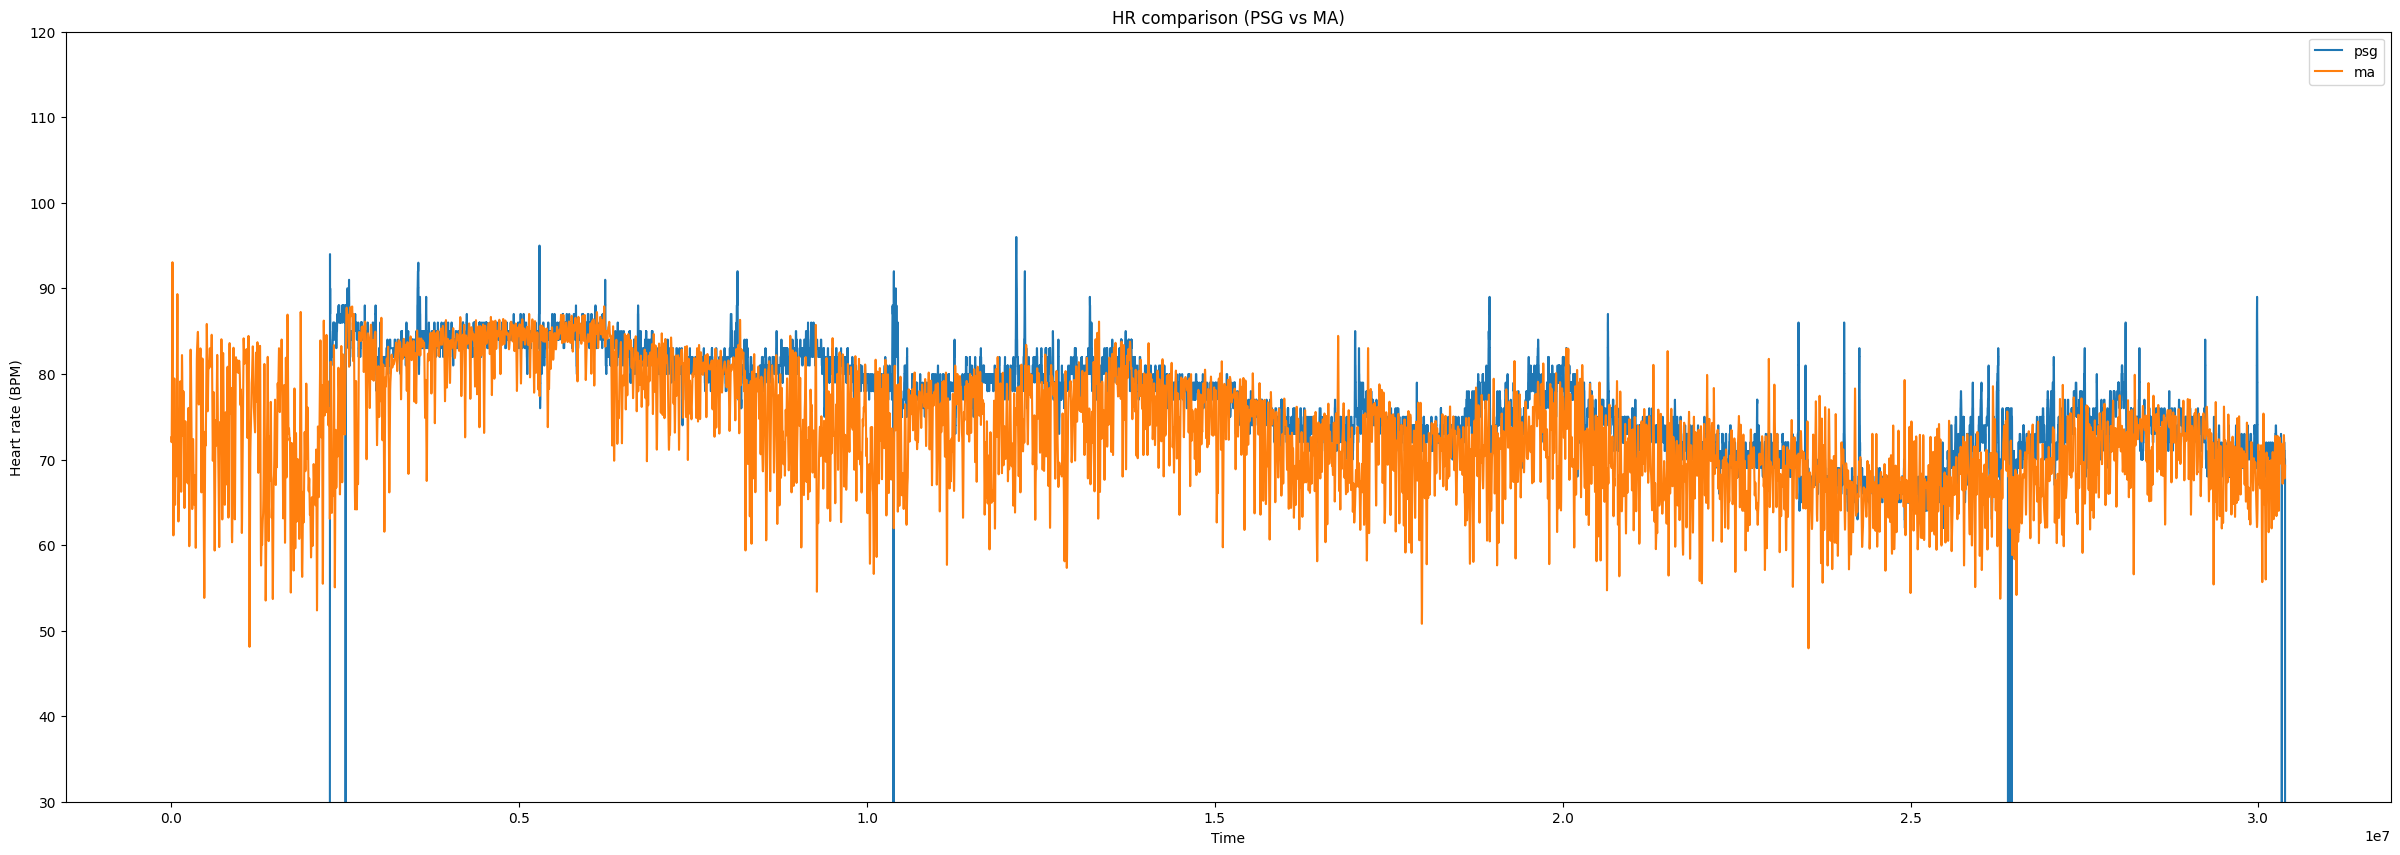

In [9]:
plt.figure(figsize=(30, 10))
my_hr = edf_ma['ma_hr'].values
plt.plot(np.arange(len(edf_ma)),edf_ma['hr'], label='psg')
plt.plot(np.arange(len(edf_ma)), my_hr, label='ma')
plt.title('HR comparison (PSG vs MA)')
plt.ylabel('Heart rate (BPM)')
plt.xlabel('Time')
plt.ylim(30, 120)
# plt.axvspan(10, 100000, alpha=0.5, color='red')
plt.legend()
plt.show()

# plt.plot(my_hr)


## Save

In [10]:
final_df.to_csv('outputs/yd003.csv')

## Playground

c:\Users\yayun\anaconda3\envs\sleepstudy\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


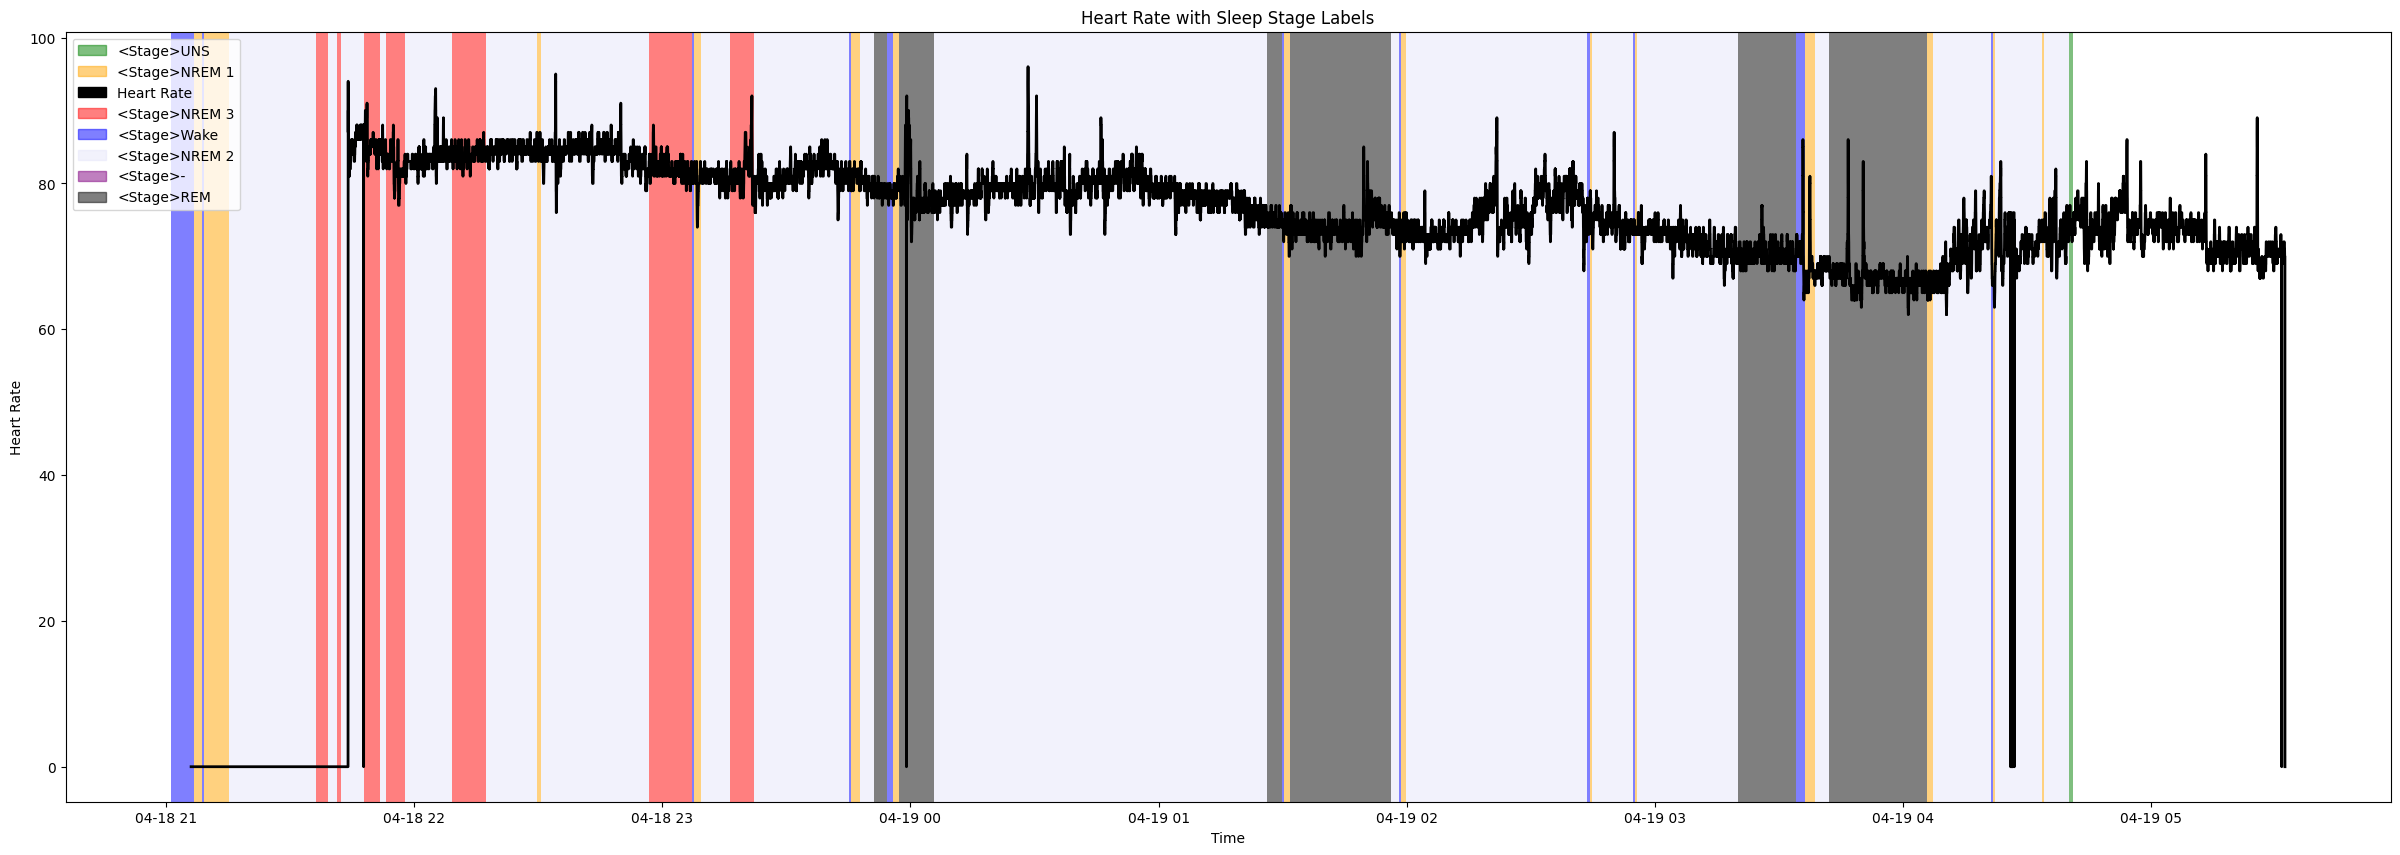

In [38]:
import matplotlib.patches as mpatches
# fig, ax = plt.subplots()
data = {
    "hr": [70, 65, 60, 75, 80, 85, 70, 65, 70, 75],
    "QuantizedStage": [0, 0, 1, 1, 2, 2, 2, 1, 0, 0]
}


df = pd.DataFrame({"hr":final_df['hr'].values, "QuantizedStage":final_df['QuantizedStage'].values})

def plot_hr_with_sleep_stage(df):
    reversed_label_map = {value: key for key, value in label_map.items()}

    fig, ax = plt.subplots(figsize=(30, 10))
    color_map = {0:'red', 1:'green', 2:'blue', 3: 'orange', 4:'black', 5: 'lavender', 6:'purple'}
    legend_patches = []
    for i in range(len(stage_index[:-1])):
        ax.axvspan(stage_index[i], stage_index[i + 1], facecolor=color_map[final_df['QuantizedStage'][stage_index[i]]], alpha=0.5)
    for k, v in reversed_label_map.items():
        legend_patches.append(mpatches.Patch(color=color_map[k], label=v, alpha=0.5))
    ax.plot(df.index, df['hr'], label='Heart Rate', color='black', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_ylabel('Heart Rate')
    ax.set_title('Heart Rate with Sleep Stage Labels')

    # Add the legend with custom patches
    ax.legend(handles=list(set(legend_patches + [mpatches.Patch(color='black', label='Heart Rate')])))
    plt.show()

plot_hr_with_sleep_stage(final_df)

In [28]:
label_map


{0: '<Stage>NREM 3',
 1: '<Stage>UNS',
 2: '<Stage>Wake',
 3: '<Stage>NREM 1',
 4: '<Stage>REM',
 5: '<Stage>NREM 2',
 6: '<Stage>-'}